In [1]:
import gym
import gym_snake

import numpy as np
import torch.nn as nn
import torch

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('snake-v0')
env.unit_gap = 0
env.grid_size = (30, 30)
env.reward_eat = 1
env.reward_win = 10
env.reward_lose = -1

In [3]:
s = env.reset()

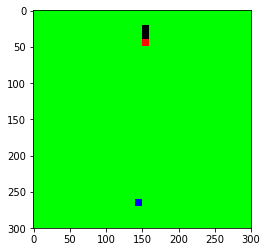

In [4]:
plt.imshow(s)

In [5]:
s, _, _, _ = env.step(1)

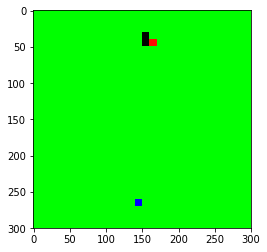

In [6]:
plt.imshow(s)

In [7]:
import cv2

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, 0) # (1, 80, 80)

In [8]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)

    def append(self, state, action, reward, next_state, done):
        self.deque.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.deque, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.deque)

In [9]:
class FrameHistory(object):
    # consecutive frame을 4개씩 병합하여 새로운 x를 하나씩 만드는 클래스
    # 만들어진 x는 4개씩 concat하고 s를 만들어서 DQN의 input으로 들어감
    def __init__(self, env, k=4):
        self.state_deque = deque(maxlen=k) # [x1, x2, x3, x4]
        self.frame_history_deque = deque(maxlen=k) #[s1, s2, s3, s4]
        self.k = k
        
        # 최초에는 초기 화면(env.reset)으로 채워둠
        self.env = env
        self.initial_state = self.preprocess(self.env.reset())
        self.reset()
        
    def preprocess(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
        return np.expand_dims(img, 0) # (1, 80, 80)
    
    def append_frame(self, s):
        # if full, aggregate and clear old frames, append new frame to history queue
        self.frame_history_deque.append(self.preprocess(s))
        
        if len(self) == self.k:
            self.state_deque.append(self.aggregate_frame())
        return
        
    def aggregate_frame(self):
        if len(self) < self.k:
            raise ValueError('not enough frames in history, expected %s, but got %s'%(self.k, len(self)))
        
        # element-wise maximum to aggregate
        frame_history = [self.frame_history_deque.popleft() for _ in range(self.k)]
        return np.maximum.reduce(frame_history[-2:]) #마지막 2 프레임 사용 
    
    def get_state(self):
        S = np.array([self.state_deque[i] for i in range(self.k)]) # S = [x1, x2, x3, x4], (4, 1, 80, 80)
        S = np.swapaxes(S, 0, 1) # (1, 4, 80, 80)
        return S
    
    def reset(self):
        self.frame_history_deque = deque(maxlen=k)
        self.state_deque = deque(maxlen=k)
        
        for _ in range(self.k):
            self.state_deque.append(self.initial_state)
    
    def __len__(self):
        return len(self.frame_history_deque)

In [10]:
class DDQN(nn.Module):
    # Dueling DQN
    def __init__(self, in_dim, n_action):
        super(DDQN, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        # V(s) : value-stream
        self.value_stream = nn.Sequential(
            nn.Linear(64*7*7, 512), nn.ReLU(), # hidden layer
            nn.Linear(512, 1)
        )
        
        # A(s,a) : action-stream
        self.action_stream = nn.Sequential(
            nn.Linear(64*7*7, 512), nn.ReLU(),
            nn.Linear(512, n_action)
        )
        
    def prep_for_input(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.prep_for_input(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        
        # key of Dueling DQN : Q(s,a_i) = V(S) + A(s,a_i) - mean(A)
        value = self.value_stream(conved) # V(s), dim=(batch_size, 1)
        action = self.action_stream(conved) # A(s,a), dim=(batch_size, n_action)
        
        output = value + (action - torch.mean(action, dim=1, keepdim=True)) # V(s) + (A(s,a_i) - mean(A)), dim=(batch_size, n_action)
        return output

In [13]:
#############
k = 1 ## number of skipped frame
#############

behavior_net = DDQN(in_dim=k, n_action=4)
target_net = DDQN(in_dim=k, n_action=4)

behavior_net.to(behavior_net.device) # model to cuda
target_net.to(target_net.device)     # model to cuda

DDQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (action_stream): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [14]:
class Fitter():
    def __init__(self, env, behavior_net, target_net, k=4, train_method='DQN'):
        self.env = env
        self.train_method = train_method
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.save_path = ('Snake_DDQN_weight')

        # networks
        self.behavior_net = behavior_net
        self.target_net = target_net
        self.behavior_net.to(self.behavior_net.device) # model to cuda
        self.target_net.to(self.target_net.device)     # model to cuda
        
        # train parameters
        self.gamma = 0.99 #as written in paper
        self.criterion = nn.SmoothL1Loss() # huber loss (error-clipping)
        self.optim = torch.optim.RMSprop(self.behavior_net.parameters(), lr=0.00025, alpha=0.95, eps=0.01) #as written in paper in Rainbow
        self.k = k
        
        # train details
        self.total_frame = 0
        self.total_episode = 0
        
        self.test_e = 0.
        self.batch_size = 32
        self.max_replay = 250000 # not as written in paper
        self.min_replay = 50000 # not as written in the paper
        self.replay_memory = ReplayMemory(self.max_replay)
        self.frame_history = FrameHistory(env=self.env, k=self.k)
        
        self.train_reward_ls = []
        self.test_reward_ls = []
    
    # train-epsilon
    @property
    def train_e(self):
        return np.max([1 - 9.0*1e-07*self.total_frame, 0.1])
    
    
    def reset_episode(self):
        # game(episode) begins
        self.env.reset()  
        self.frame_history.reset() #frame history reset
        self.current_episode_frame = 0         # each episode의 frame 수 
        self.current_episode_reward = 0        # each episode의 reward 합
    
    def choose_action(self, S, e):
        # Choose an action by e-greedy
        if np.random.rand(1) < e :
            a = self.env.action_space.sample()
        else:
            q_behavior = self.behavior_net(S)
            a = torch.argmax(q_behavior).item()
        return a
    
    
    def run_k_frames(self, e):
        # choose action!
        S = self.frame_history.get_state()
        a = self.choose_action(S, e)
        r_sum = 0
        
        # repeat the action k-times
        for _ in range(self.k):
            s_next, r, done, info = self.env.step(a)
            self.frame_history.append_frame(s_next)
            r_sum += r 
            
            # accumulate history
            self.current_episode_frame += 1
            self.current_episode_reward += r
            
            # if episode(game) ends, return done(True)
            if done: 
                return done
            
        # concat last k-frames into a next state S_next
        S_next = self.frame_history.get_state()
        
        # save replay(experience)
        self.replay_memory.append(S, a, r_sum, S_next, done) 
            
        return done

    
    def train(self, max_total_frame):
        while self.total_frame < max_total_frame :
            # episode starts!
            self.reset_episode()
            
            done = False
            while not done:
                done = self.run_k_frames(e=self.train_e)
                
                # training when enough replay-memory, every k-frames
                if len(self.replay_memory) > self.min_replay:
                    self.train_batch(self.batch_size)   
                    self.total_frame += self.k
                    
                    # update target_net every 10,000 updates
                    if self.total_frame%(self.k*10000)== 0 :
                        self.update_target()
                        self.save()
                
            # single-episode(game) is now done
            # if not enough memory, save more
            if len(self.replay_memory) < self.min_replay:
                print('Not enough replay yet, expected more than %s, but %s instead'%(self.min_replay, len(self.replay_memory)))
            
            # if enough memory, print train result
            else:
                self.total_episode += 1
                
                if self.total_episode%100 == 0:
                    print('Train Episode :%s, Total Frame : %s, Train reward : %s,'%(self.total_episode, self.total_frame, self.current_episode_reward))
                    self.train_reward_ls.append(self.current_episode_reward)
            
                # testing, every 10 episodes when enough replay
                if self.total_episode%1000 == 0:
                    self.test()           

    def train_batch(self, batch_size):
        # get mini-batch from replay-memory
        S, A, R, S_next, D = self.replay_memory.sample(batch_size)
        A = self.to_tensor(A, dtype=torch.long)
        R = self.to_tensor(R, dtype=torch.float32)
        D = self.to_tensor(D, dtype=torch.float32)
        
        q_behaviors = self.behavior_net(S)                # Q-values for every possible actions
        q_behavior = self.select_indices(q_behaviors, A) # select Q-value for given actions
        
        if self.train_method=='DQN':
            q_targets_next = self.target_net(S_next)   # Q-values of every possible actions next state (targetDQN)
            q_target_next = q_targets_next.max(1)[0]   # max Q-values of next state
            q_target = R + self.gamma*q_target_next*(1-D) 
        
        elif self.train_method=='DoubleDQN':
            next_actions = torch.argmax(self.behavior_net(S_next), dim=1) # choose argmax behavior actions at S_next
            
            q_targets_next = self.target_net(S_next) # cal Q-values of every possible actions next state (targetDQN)
            q_target_next = self.select_indices(q_targets_next, next_actions) # select Q-value for next behavior actions
            q_target = R + self.gamma*q_target_next*(1-D)
        
        # update weights
        self.optim.zero_grad()
        loss = self.criterion(q_target, q_behavior)
        loss.backward()
        self.optim.step()
        return
        
    def to_tensor(self, x, dtype=torch.float):
        return torch.tensor(x, dtype=dtype, device=self.device)
    
    def select_indices(self, tensor, indices, dim=1):
        if type(indices) != torch.Tensor:
            indices = self.to_tensor(indices, dtype=torch.long)
        if indices.dim() < 2 :
            indices = indices.unsqueeze(1)
        return tensor.gather(dim, indices).squeeze(1)
    
    def clip_reward(self, r):
        return np.sign(r)
    
    
    def update_target(self):
        print('Update Target')
        self.target_net.load_state_dict(self.behavior_net.state_dict())
        return 
    
    def test(self):
        self.reset_episode()
        done=False
        while not done:
            done = self.run_k_frames(e=fitter.test_e) # e-greedy
                
        self.test_reward_ls.append(self.current_episode_reward)
        print('※Test※ \t Frames: %s \t Score: %s'%(self.current_episode_frame, self.current_episode_reward))
        return
     
    def save(self):
        torch.save(self.behavior_net.state_dict(), self.save_path)

In [15]:
fitter = Fitter(env, behavior_net, target_net, k=k, train_method='DoubleDQN')

In [ ]:
max_frame = 50000000
fitter.train(max_frame)

Update Target
Train Episode :5100, Total Frame : 397006, Train reward : -1,
Update Target
Train Episode :5200, Total Frame : 406832, Train reward : -1,
Update Target
Train Episode :5300, Total Frame : 418059, Train reward : -1,
Update Target
Train Episode :5400, Total Frame : 427120, Train reward : -1,
Update Target
Train Episode :5500, Total Frame : 437012, Train reward : -1,
Update Target
Train Episode :5600, Total Frame : 448213, Train reward : -1,
Update Target
Train Episode :5700, Total Frame : 458075, Train reward : 0,
Update Target
Train Episode :5800, Total Frame : 469113, Train reward : -1,
Update Target
Update Target
Train Episode :5900, Total Frame : 485573, Train reward : -1,
Update Target
